In [2]:
import numpy as np
from numpy import loadtxt
from google.colab import drive
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [3]:
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive


In [5]:
def loadData(isCONVfirstLayer, valPercentage):
  trainX = np.loadtxt("PsiloClassifier/dataSplit/trainX2.csv", delimiter= ",")
  trainY = np.loadtxt("PsiloClassifier/dataSplit/trainY2.csv", delimiter= ",")
  testX = np.loadtxt("PsiloClassifier/dataSplit/testX2.csv", delimiter= ",")
  testY = np.loadtxt("PsiloClassifier/dataSplit/testY2.csv", delimiter= ",")
  valX = np.loadtxt("PsiloClassifier/dataSplit/valX2.csv", delimiter= ",")
  valY = np.loadtxt("PsiloClassifier/dataSplit/valY2.csv", delimiter= ",")
  
  if(isCONVfirstLayer):
    shape = trainX.shape
    samples = shape[0]
    timesteps = shape[1]
    trainX = trainX.reshape(samples, 1, timesteps)

    shape= testX.shape
    samples = shape[0]
    timesteps = shape[1]
    testX = testX.reshape(samples, 1, timesteps)

    shape= valX.shape
    samples = shape[0]
    timesteps = shape[1]
    valX = valX.reshape(samples, 1, timesteps)

  trainX = trainX.astype('float32')
  testX = testX.astype('float32')
  valX = valX.astype('float32')
  trainY = trainY.astype('float32').reshape((-1,1))
  testY = testY.astype('float32').reshape((-1,1))
  valY = valY.astype('float32').reshape((-1,1))

  trainX = torch.tensor(trainX)
  trainY = torch.tensor(trainY)
  testX = torch.tensor(testX)
  testY = torch.tensor(testY)
  valX = torch.tensor(valX)
  valY = torch.tensor(valY)

  return trainX, trainY, valX, valY, testX, testY

In [6]:
def createDataset(trainX, trainY, valX, valY):
  train_ds = TensorDataset(trainX, trainY)
  val_ds = TensorDataset(valX, valY)
  return train_ds, val_ds

In [7]:
def createDataLoaders(train_ds, val_ds, bs):
  train_dl = DataLoader(train_ds, bs, shuffle=False)
  val_dl = DataLoader(val_ds, bs, shuffle=False)
  return train_dl, val_dl

In [128]:
sigmoid = nn.Sigmoid()
criterion = nn.BCELoss()

def c_out_length(in_length, kernel_size, padding=0, dilation=1, stride=1):
  length_out = ((in_length + 2*padding - dilation*(kernel_size - 1) - 1) / stride ) + 1
  return length_out

class ConvClassifier(nn.Module):
  def __init__(self, sample_length, num_filters, kernel_size, pool_kernel_size, output_dim):
    super().__init__()
    self.sample_length = sample_length
    self.num_filters = num_filters
    self.pool_kernel_size = pool_kernel_size

    self.conv = nn.Conv1d(1, num_filters, kernel_size)
    self.pool = nn.MaxPool1d(pool_kernel_size)
    
    conv_out_length = c_out_length(sample_length, kernel_size)
    pool_out_length = int(conv_out_length/pool_kernel_size)
    fully_connected_input = int(pool_out_length * num_filters)

    self.fc_input = fully_connected_input
    self.fc = nn.Linear(fully_connected_input, output_dim)

  def forward(self, x):
    x = self.conv(x)
    x = self.pool(x)
    x = x.view(-1, self.fc_input)
    x = self.fc(x)
    x = sigmoid(x)
    return x

def accuracyAndLoss(data_loader, model):
  total, correct, loss, batches = 0, 0, 0, 0
  model.eval()
  for x, y in data_loader:
    out = model(x)
    preds = out.round()
    total += y.size(0)
    batches += 1
    correct += (preds == y).sum().item()
    loss += criterion(out, y)
  return correct/total, loss/batches

In [9]:
trainX, trainY, valX, valY, testX, testY = loadData(True, 20)
train_ds, val_ds = createDataset(trainX, trainY, valX, valY)
train_dl, val_dl = createDataLoaders(train_ds, val_ds, bs=512)

In [125]:
def train_model(lr, epochs, sample_length, num_filters, kernel_size, pool_kernel_size, plot=False):
  model = ConvClassifier(sample_length, num_filters, kernel_size, pool_kernel_size, 1)
  criterion = nn.BCELoss()
  opt = torch.optim.RMSprop(model.parameters(), lr=lr)
  train_accuracy = []
  val_accuracy = []
  train_loss = []
  val_loss = []

  print('Starting model training... lr:', lr, ' epochs:', epochs,  ' num_filters:', num_filters, ' kernel_size:', kernel_size, ' pool_kernel_size:', pool_kernel_size)

  for epoch in range(epochs):
      for i, (x_batch, y_batch) in enumerate(train_dl):
          model.train()
          x_batch = x_batch
          y_batch = y_batch
          opt.zero_grad()
          out = model(x_batch)
          loss = criterion(out, y_batch)
          loss.backward()
          opt.step()
      
      with torch.no_grad():
        train_accuracy_, train_loss_ = accuracyAndLoss(train_dl, model)
        train_accuracy.append(train_accuracy_)
        train_loss.append(train_loss_)
        val_accuracy_, val_loss_ = accuracyAndLoss(val_dl, model)
        val_accuracy.append(val_accuracy_)
        val_loss.append(val_loss_)

  if plot == True: 
    plt.subplot(2,1,1)
    plt.plot(train_accuracy, 'b')
    plt.title("accuracy")
    plt.plot(val_accuracy, 'r')

    plt.subplot(2,1,2)
    plt.plot(train_loss, 'b')
    plt.title("loss")
    plt.plot(val_loss, 'r')

    plt.tight_layout()
    plt.show()

  print('Training complete! train_accuracy:', round(train_accuracy[-1], 3), ' val_accuracy:', round(val_accuracy[-1], 3), ' train_loss:', round(train_loss[-1].item(), 3), ' val_loss:', round(val_loss[-1].item(), 3) )

  return train_accuracy, val_accuracy, train_loss, val_loss, model;

In [140]:
#stores all information relevant to a model trained using random parameter search
class trainedModel:
  def __init__(self, lr, epochs, num_filters, kernel_size, pool_kernel_size, train_accuracy, val_accuracy, train_loss, val_loss):
    self.lr = lr
    self.epochs = epochs
    self.num_filters = num_filters
    self.kernel_size = kernel_size
    self.pool_kernel_size = pool_kernel_size
    self.train_accuracy = train_accuracy
    self.val_accuracy = val_accuracy
    self.train_loss = train_loss
    self.val_loss = val_loss
    self.final_val_accuracy = val_accuracy[-1]

  def __gt__(self, other):
    return self.final_val_accuracy > other.final_val_accuracy

#searches for optimal parameters within intervals of lr, epoch, etc. using uniform distribution. keeps and returns top 10 model objects (not their parameters, just their hyperparameters)
def paramSearch(reps, lr_min, lr_max, epoch_min, epoch_max, nf_min, nf_max, ks_min, ks_max, pks_min, pks_max):
  num_models_to_keep = 10
  best_trained_models = []

  for rep in range(reps):
    lr = np.random.uniform(lr_min, lr_max)
    epochs = int(np.random.uniform(epoch_min, epoch_max))
    num_filters = int(np.random.uniform(nf_min, nf_max))
    kernel_size = int(np.random.uniform(ks_min, ks_max))
    pool_kernel_size = int(np.random.uniform(pks_min, pks_max))

    train_accuracy, val_accuracy, train_loss, val_loss, model = train_model(lr, epochs, 250, num_filters, kernel_size, pool_kernel_size, plot=False)
    trained_model = trainedModel(lr, epochs, num_filters, kernel_size, pool_kernel_size, train_accuracy, val_accuracy, train_loss, val_loss)

    if len(best_trained_models) < num_models_to_keep: 
      best_trained_models.append(trained_model)
      best_trained_models.sort(key=lambda x: x.final_val_accuracy, reverse=True)
    else:
      if trained_model > best_trained_models[num_models_to_keep - 1]:
        best_trained_models[num_models_to_keep - 1] = trained_model
        best_trained_models.sort(key=lambda x: x.final_val_accuracy, reverse=True)

  for i, x in enumerate(best_trained_models):
    print(i,': ' , x.final_val_accuracy, ' lr: ', x.lr, ' epochs:', x.epochs, ' num_filters:', x.num_filters, ' kernel_size:', x.kernel_size, ' pool_kernel_size:', x.pool_kernel_size)
  return best_trained_models

In [143]:
x = []
x = paramSearch(40, 0.001, 0.02, 1, 6, 1, 10, 5, 100, 5, 100)

Starting model training... lr: 0.017860190015564006  epochs: 3  num_filters: 7  kernel_size: 39  pool_kernel_size: 34
Training complete! train_accuracy: 0.674  val_accuracy: 0.658  train_loss: 0.59  val_loss: 0.648
Starting model training... lr: 0.0018175153660627778  epochs: 2  num_filters: 9  kernel_size: 99  pool_kernel_size: 89
Training complete! train_accuracy: 0.668  val_accuracy: 0.644  train_loss: 0.599  val_loss: 0.671
Starting model training... lr: 0.008224223587072546  epochs: 5  num_filters: 2  kernel_size: 77  pool_kernel_size: 95
Training complete! train_accuracy: 0.649  val_accuracy: 0.638  train_loss: 0.618  val_loss: 0.667
Starting model training... lr: 0.015430089687711274  epochs: 5  num_filters: 2  kernel_size: 82  pool_kernel_size: 69
Training complete! train_accuracy: 0.664  val_accuracy: 0.643  train_loss: 0.603  val_loss: 0.659
Starting model training... lr: 0.009189315409368789  epochs: 4  num_filters: 9  kernel_size: 89  pool_kernel_size: 39
Training complete!

Starting model training... lr: 0.01  epochs: 4  num_filters: 2  kernel_size: 6  pool_kernel_size: 22


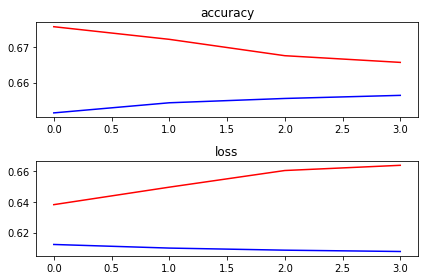

Training complete! train_accuracy: 0.656  val_accuracy: 0.666  train_loss: 0.608  val_loss: 0.664


In [145]:
a, b, c, d, model = train_model(0.01, 4, 250, 2, 6, 22, True)